## In this notebook, we'll analyze the labels we are left with after the initial filtering pass
Labels are generated in the candidate_label_creation notebook and then filtered in the candidate_filter notebook.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utility import run_command

### Parameters
**Required**  
*work_dir*: path to work_dir that was specified in candidate_label_creation and candidate_filter notebooks. This should contain a folder called label_creation and a folder called candidate_filter.  
*store_dir*: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.  
*label_file*: file path for the file that contains wikidata labels.

In [2]:
# **REQUIRED**
work_dir = "../../Q44/profiler_work"
store_dir = "../../Q44"
label_file = "../../Q44/data/Q44.label.en.tsv"

### Process params / set up variables

In [3]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
label_file = os.path.abspath(label_file)

label_creation_dir = "{}/label_creation".format(work_dir)
filter_dir = "{}/candidate_filter".format(work_dir)
    
# Create output directory
output_dir = "{}/analyze_filtered_labels".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['LABEL_CREATION'] = label_creation_dir
os.environ['FILTERED_LABELS'] = filter_dir
os.environ['LABEL_FILE'] = label_file
os.environ["OUT"] = output_dir
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

## pre-processing...
To make labels easier to look through, we'll:
1. Add human readable labels* for Wikidata nodes and properties.
2. Add a label-kind column to our labels so that we can key on this after we combine the labels into a single table.
3. Add a column for number of entities of type = label's type
4. Standardize/disambiguate column headers across label kinds so they can be combined into a single table.

*sorry for the ambiguous wording here - "labels" in this sentence refers to a different thing than the labels we are analyzing in this notebook

**AVLs**

In [4]:
if not os.path.isfile("{}/candidate_labels_avl_string_filtered.tsv".format(filter_dir)):
    string_file_exists = False
    print("No string labels file found, skipping this step.")
else:
    string_file_exists = True
    # perform query
    command = "$kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_string_filtered.tsv \
               -i LABEL_FILE -o $OUT/filtered_avl_string_analysis.tsv \
               --graph-cache $STORE \
               --match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `LABEL_FILE`: (type)-[]->(type_lab)' \
               --return 'distinct \"AVL\" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, \"\" as val1_lab, \"\" as val1_ub, \"\" as type2, \"\" as type2_lab, \"\" as prop2, \"\" as prop2_lab, \"\" as val2, \"\" as val2_ub, \"\" as si_units, \"\" as wd_units' \
               --where 'type_lab.kgtk_lqstring_lang_suffix = \"en\"'"
    run_command(command, {"LABEL_FILE" : label_file})

No string labels file found, skipping this step.


In [5]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_quantity_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_avl_quantity_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

In [6]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_avl_time.year_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_avl_time.year_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

**RELs**

In [7]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_rel_item_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_rel_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab), `'"$LABEL_FILE"'`: (val)-[]->(val_lab)' \
--return 'distinct "REL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, val_lab as val1_lab, "" as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en" AND val_lab.kgtk_lqstring_lang_suffix = "en"'

**AILs**

In [8]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ail_quantity_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ail_quantity_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, prop_label:prop_lab, upper_bound:ub, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, ub as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

In [9]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ail_time.year_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ail_time.year_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, support:sup, upper_bound:ub, prop_label:prop_lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (type)-[]->(type_lab)' \
--return 'distinct "AIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type as type1, type_lab as type1_lab, prop as prop1, prop_lab as prop1_lab, val as val1, "" as val1_lab, ub as val1_ub, "" as type2, "" as type2_lab, "" as prop2, "" as prop2_lab, "" as val2, "" as val2_ub, "" as si_units, "" as wd_units' \
--where 'type_lab.kgtk_lqstring_lang_suffix = "en"'

**RAVLs**

In [10]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_ravl_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_ravl_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, support:sup, prop2_label:prop2_lab, val:val2, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[]->(type2_lab)' \
--return 'distinct "RAVL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type1 as type1, type1_lab as type1_lab, prop1 as prop1, prop1_lab as prop1_lab, "" as val1, "" as val1_lab, "" as val1_ub, type2 as type2, type2_lab as type2_lab, prop2 as prop2, prop2_lab as prop2_lab, val2 as val2, "" as val2_ub, si as si_units, wd as wd_units' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"'


**RAILs**

In [11]:
!kgtk query -i $LABEL_CREATION/entity_counts_per_type.tsv -i $FILTERED_LABELS/candidate_labels_rail_filtered.tsv \
-i $LABEL_FILE -o $OUT/filtered_rail_analysis.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, support:sup, prop2_label:prop2_lab, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[]->(type2_lab)' \
--return 'distinct "RAIL" as label_kind, pos as positives, count as num_type1_ents, sup as support, type1 as type1, type1_lab as type1_lab, prop1 as prop1, prop1_lab as prop1_lab, "" as val1, "" as val1_lab, "" as val1_ub, type2 as type2, type2_lab as type2_lab, prop2 as prop2, prop2_lab as prop2_lab, lb as val2, ub as val2_ub, si as si_units, wd as wd_units' \
--where 'type1_lab.kgtk_lqstring_lang_suffix = "en" AND prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en"'


Defining filename variables and the order of columns in our analysis files since we'll need thess in a couple places.

In [12]:
if string_file_exists:
    avl_string_file = "{}/filtered_avl_string_analysis.tsv".format(output_dir)
avl_quantity_file = "{}/filtered_avl_quantity_analysis.tsv".format(output_dir)
avl_year_file = "{}/filtered_avl_time.year_analysis.tsv".format(output_dir)
rel_file = "{}/filtered_rel_analysis.tsv".format(output_dir)
ail_quantity_file = "{}/filtered_ail_quantity_analysis.tsv".format(output_dir)
ail_year_file = "{}/filtered_ail_time.year_analysis.tsv".format(output_dir)
ravl_file = "{}/filtered_ravl_analysis.tsv".format(output_dir)
rail_file = "{}/filtered_rail_analysis.tsv".format(output_dir)
all_file = "{}/filtered_all_analysis.tsv".format(output_dir)

all_cols = ["label_kind","positives", "num_type1_ents", "support", "type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_lab", "val1_ub", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "val2_ub", "si_units", "wd_units"]
avl_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "si_units", "wd_units","positives", "num_type1_ents", "support"]
rel_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_lab", "positives", "num_type1_ents", "support"]
ail_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "val1", "val1_ub", "si_units", "wd_units", "positives", "num_type1_ents", "support"]
ravl_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "si_units", "wd_units", "positives", "num_type1_ents", "support"]
rail_cols = ["type1", "type1_lab", "prop1", "prop1_lab", "type2", "type2_lab", "prop2", "prop2_lab", "val2", "val2_ub", "si_units", "wd_units", "positives", "num_type1_ents", "support"]


Creating a combined analysis files

In [14]:
df = pd.read_csv(avl_quantity_file, delimiter = '\t')
if string_file_exists:
    df = df.append(pd.read_csv(avl_string_file, delimiter = '\t'))
df = df.append(pd.read_csv(avl_year_file, delimiter = '\t'))
df = df.append(pd.read_csv(rel_file, delimiter = '\t'))
df = df.append(pd.read_csv(ail_quantity_file, delimiter = '\t'))
df = df.append(pd.read_csv(ail_year_file, delimiter = '\t'))
df = df.append(pd.read_csv(ravl_file, delimiter = '\t'))
df = df.append(pd.read_csv(rail_file, delimiter = '\t'))

df[all_cols].to_csv(path_or_buf = all_file, sep = '\t', index = False)

Helper function for viewing label support / positives distribution

In [15]:
"""
Given a file containing labels, optionally filter by the labels' type1,
plot label support and label count histograms, and print out some examples
of labels at various bins of the histograms.
"""
def plot_label_supports_and_positives(filename, cols_to_print_in_order, type1 = None,
                                      log_scale_supports = False, log_scale_positives = False):
    df = pd.read_csv(filename, delimiter = '\t')
    # We get NA when reading blank cells.
    # Blank cells are expected, so we'll change them back to avoid confusion when displaying
    df.fillna("", inplace = True) 
    
    if type1 is not None:
        df = df.loc[df.loc[:,"type1"] == type1]
        
    supports = df.loc[:,"support"]
    positives = df.loc[:,"positives"]
    
    fig, (ax_sup, ax_pos) = plt.subplots(1, 2, figsize = (14,5))
    
    ax_sup.hist(supports, bins = np.arange(0,1.01,.02))
    ax_sup.set_xlabel("Support (# positives for this label / # entities with this label's type)")
    ax_sup.set_ylabel("# Labels")
    ax_sup.set_title("Distribution of Support for Labels")
    if log_scale_supports:
        ax_sup.set_yscale("log")
    
    ax_pos.hist(positives, bins = range(0,max(positives)+2,1), align = "left")
    ax_pos.set_xlabel("# Positives")
    ax_pos.set_ylabel("# Labels")
    ax_pos.set_title("Distribution of Number of Positives for Labels")
    if log_scale_positives:
        ax_pos.set_yscale("log")
 
    plt.tight_layout()
    plt.show()
    
    # Show some examples of labels in various bins of the histograms
    
    print("Examples of labels at several values of support...")
    unique_supports_sorted = sorted(set(supports))
    examples_df = pd.DataFrame()
    num_to_show = 5
    num_shown_from_bin = {} # If we have few bins, we may show more than one example from a bin. Don't show duplicates.
    for i in range(num_to_show):
        # Get the bin value to show examples from
        sup = unique_supports_sorted[int((i/4) * (len(unique_supports_sorted)-1))]
        if sup not in num_shown_from_bin:
            num_shown_from_bin[sup] = 0
        ix_to_choose = num_shown_from_bin[sup]
        examples_in_bin = df.loc[df.loc[:,"support"] == sup]
        if ix_to_choose < len(examples_in_bin):
            examples_df = examples_df.append(examples_in_bin.iloc[ix_to_choose])
            num_shown_from_bin[sup] += 1
    display(examples_df[cols_to_print_in_order])
        
    print("\nExamples of labels at several values of positives...")
    unique_positives_sorted = sorted(set(positives))
    examples_df = pd.DataFrame()
    num_shown_from_bin = {} # If we have few bins, we may show more than one example from a bin. Don't show duplicates.
    for i in range(num_to_show):
        # Get the bin value to show examples from
        pos = unique_positives_sorted[int((i/4) * (len(unique_positives_sorted)-1))]
        if pos not in num_shown_from_bin:
            num_shown_from_bin[pos] = 0
        ix_to_choose = num_shown_from_bin[pos]
        examples_in_bin = df.loc[df.loc[:,"positives"] == pos]
        if ix_to_choose < len(examples_in_bin):
            examples_df = examples_df.append(examples_in_bin.iloc[ix_to_choose])
            num_shown_from_bin[pos] += 1
    display(examples_df[cols_to_print_in_order])

### AVL - string

In [16]:
if not string_file_exists:
    print("No string labels file found, skipping this step.")
else:
    plot_label_supports_and_positives(avl_string_file, avl_cols, log_scale_positives = True)

No string labels file found, skipping this step.


### AVL - year

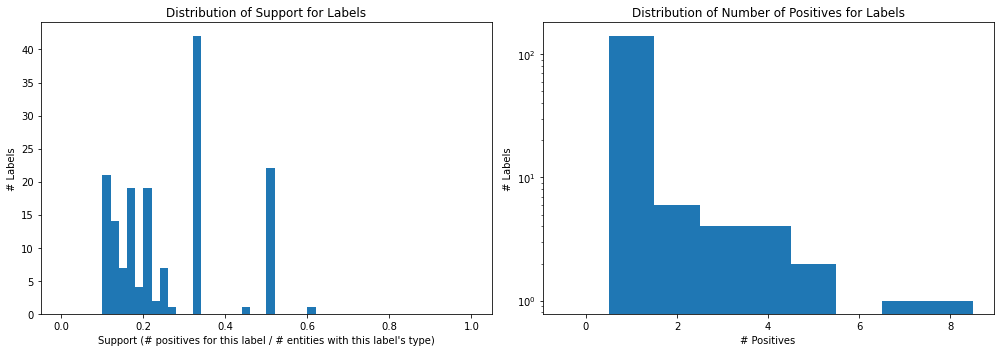

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q431289,'brand'@en,P571,'inception'@en,1873.0,,,1.0,10.0,0.1000
21,Q1549591,'big city'@en,P1249,'time of earliest written record'@en,-400.0,,,1.0,8.0,0.1250
62,Q179164,'unitary state'@en,P571,'inception'@en,1918.0,,,3.0,16.0,0.1875
86,Q179164,'unitary state'@en,P571,'inception'@en,1991.0,,,4.0,16.0,0.2500
159,Q619610,'social state'@en,P571,'inception'@en,1991.0,,,3.0,5.0,0.6000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q431289,'brand'@en,P571,'inception'@en,1873.0,,,1.0,10.0,0.100000
10,Q7270,'republic'@en,P571,'inception'@en,1821.0,,,2.0,18.0,0.111111
84,Q7270,'republic'@en,P571,'inception'@en,1918.0,,,4.0,18.0,0.222222
63,Q6256,'country'@en,P571,'inception'@en,1918.0,,,5.0,26.0,0.192308
20,Q3624078,'sovereign state'@en,P571,'inception'@en,1991.0,,,8.0,69.0,0.115942


In [17]:
plot_label_supports_and_positives(avl_year_file, avl_cols, log_scale_positives = True)

### AVL - quantity

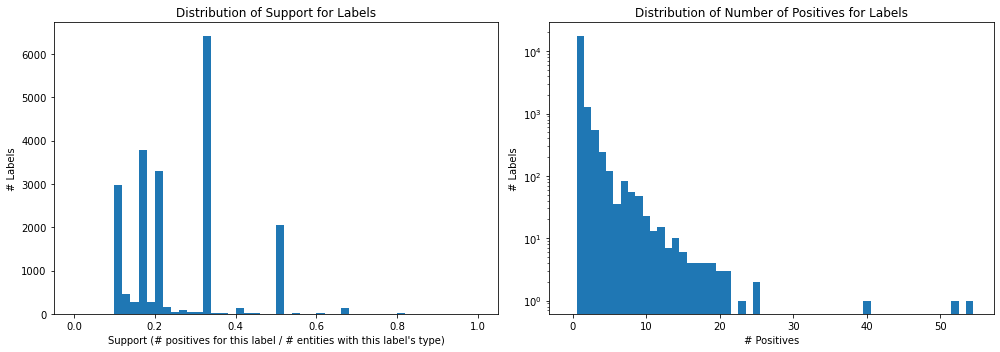

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q431289,'brand'@en,P2665,'alcohol by volume'@en,0.400,,Q2080811,1.0,10.0,0.100000
7742,Q123480,'landlocked country'@en,P1081,'Human Development Index'@en,0.719,,,3.0,15.0,0.200000
11380,Q6256,'country'@en,P1081,'Human Development Index'@en,0.849,,,8.0,26.0,0.307692
20076,Q112099,'island nation'@en,P1279,'inflation rate'@en,1.500,,Q11229,6.0,11.0,0.545455
20275,Q179164,'unitary state'@en,P2997,'age of majority'@en,18.000,,Q24564698,14.0,16.0,0.875000



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
0,Q431289,'brand'@en,P2665,'alcohol by volume'@en,0.400,,Q2080811,1.0,10.0,0.100000
9,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.648,,,7.0,69.0,0.101449
7693,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.728,,,13.0,69.0,0.188406
11325,Q3624078,'sovereign state'@en,P1279,'inflation rate'@en,1.500,,Q11229,19.0,69.0,0.275362
20255,Q3624078,'sovereign state'@en,P3000,'marriageable age'@en,18.000,,Q24564698,54.0,69.0,0.782609


In [18]:
plot_label_supports_and_positives(avl_quantity_file, avl_cols, log_scale_positives = True)

### AIL - year

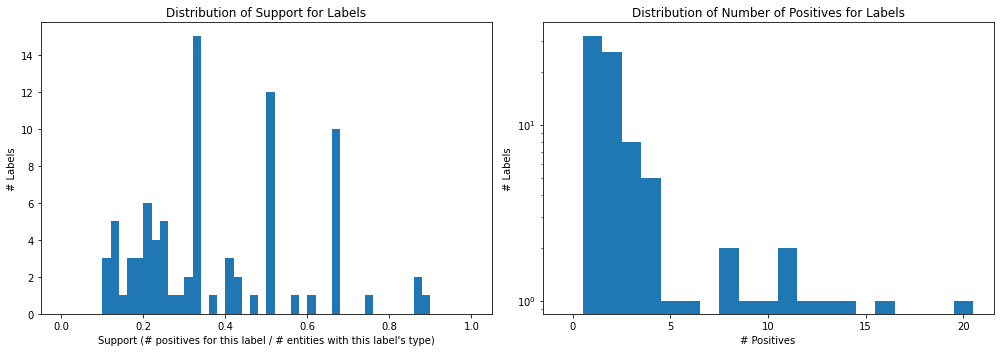

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q131734,'brewery'@en,P571,'inception'@en,,1797,,,9.0,87.0,0.103448
13,Q131734,'brewery'@en,P571,'inception'@en,1797,1922.5,,,16.0,87.0,0.183908
31,Q40050,'drink'@en,P571,'inception'@en,2015,,,,2.0,7.0,0.285714
55,Q6881511,'enterprise'@en,P571,'inception'@en,1905.5,,,,11.0,23.0,0.478261
83,Q63791824,'countries bordering the Baltic Sea'@en,P571,'inception'@en,1441.5,,,,8.0,9.0,0.888889



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
1,Q63791824,'countries bordering the Baltic Sea'@en,P571,'inception'@en,,750,,,1.0,9.0,0.111111
21,Q7270,'republic'@en,P571,'inception'@en,,1635.5,,,4.0,18.0,0.222222
0,Q131734,'brewery'@en,P571,'inception'@en,,1797,,,9.0,87.0,0.103448
11,Q3624078,'sovereign state'@en,P571,'inception'@en,581.5,1370.5,,,12.0,69.0,0.173913
23,Q131734,'brewery'@en,P571,'inception'@en,1922.5,,,,20.0,87.0,0.229885


In [19]:
plot_label_supports_and_positives(ail_year_file, ail_cols, log_scale_positives = True)

### AIL - quantity

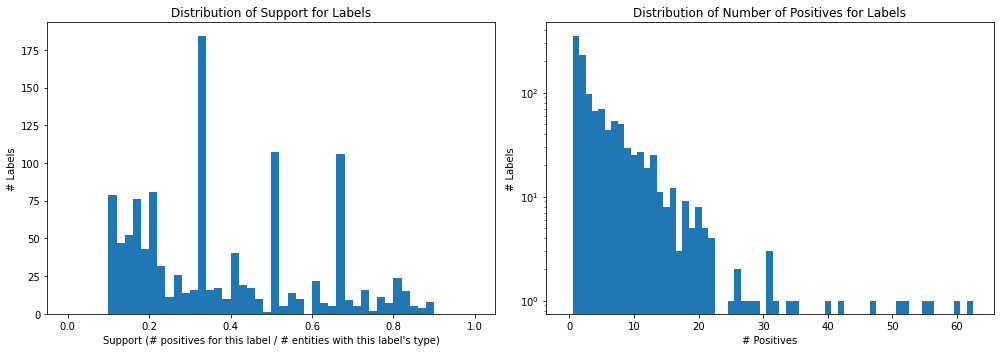

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q4830453,'business'@en,P1128,'employees'@en,,103678,,,5.0,50.0,0.100000
421,Q3624078,'sovereign state'@en,P1082,'population'@en,8.14157e+07,8.30642e+07,,,18.0,69.0,0.260870
756,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.649,0.659,,,7.0,16.0,0.437500
1067,Q3624078,'sovereign state'@en,P2855,'VAT-rate'@en,14,26,,Q11229,47.0,69.0,0.681159
1172,Q3624078,'sovereign state'@en,P2132,'nominal GDP per capita'@en,52275,,,Q4917,62.0,69.0,0.898551



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
1,Q431289,'brand'@en,P2665,'alcohol by volume'@en,,2.7,,Q2080811,1.0,10.0,0.100000
147,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.4645,0.4705,,,10.0,69.0,0.144928
455,Q3624078,'sovereign state'@en,P1082,'population'@en,6.23098e+07,6.45956e+07,,,20.0,69.0,0.289855
790,Q3624078,'sovereign state'@en,P3001,'retirement age'@en,,,,Q24564698,34.0,69.0,0.492754
1172,Q3624078,'sovereign state'@en,P2132,'nominal GDP per capita'@en,52275,,,Q4917,62.0,69.0,0.898551


In [20]:
plot_label_supports_and_positives(ail_quantity_file, ail_cols, log_scale_positives = True)

### RELs

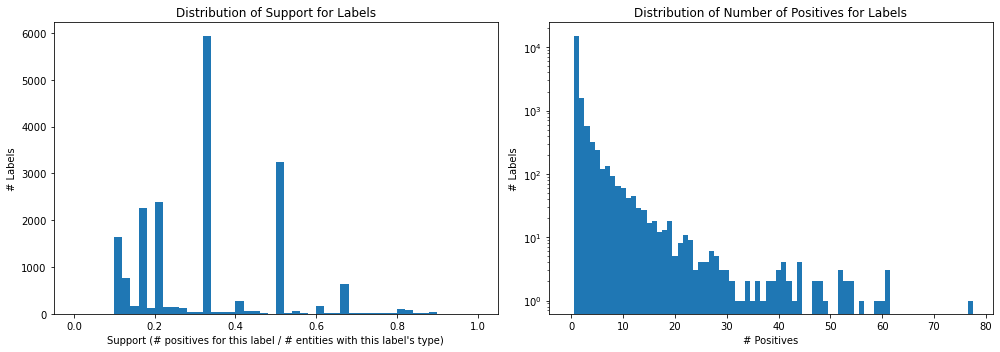

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
0,Q4830453,'business'@en,P17,'country'@en,Q31,'Belgium'@en,5.0,50.0,0.100000
7684,Q112099,'island nation'@en,P122,'basic form of government'@en,Q7270,'republic'@en,3.0,11.0,0.272727
14253,Q112099,'island nation'@en,P1343,'described by source'@en,Q19180675,'Small Brockhaus and Efron Encyclopedic Dictio...,5.0,11.0,0.454545
18456,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,Q403,'Serbia'@en,47.0,69.0,0.681159
18759,Q7270,'republic'@en,P1622,'driving side'@en,Q14565199,'right'@en,16.0,18.0,0.888889



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
2,Q431289,'brand'@en,P112,'founded by'@en,Q1037888,'Carl Frederik Tietgen'@en,1.0,10.0,0.100000
7281,Q3624078,'sovereign state'@en,P206,'located in or next to body of water'@en,Q4918,'Mediterranean Sea'@en,14.0,69.0,0.202899
14149,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,Q159583,'Holy See'@en,28.0,69.0,0.405797
17612,Q3624078,'sovereign state'@en,P30,'continent'@en,Q46,'Europe'@en,41.0,69.0,0.594203
18758,Q131734,'brewery'@en,P452,'industry'@en,Q869095,'brewing'@en,77.0,87.0,0.885057


In [21]:
plot_label_supports_and_positives(rel_file, rel_cols, log_scale_positives = True)

### RAVLs

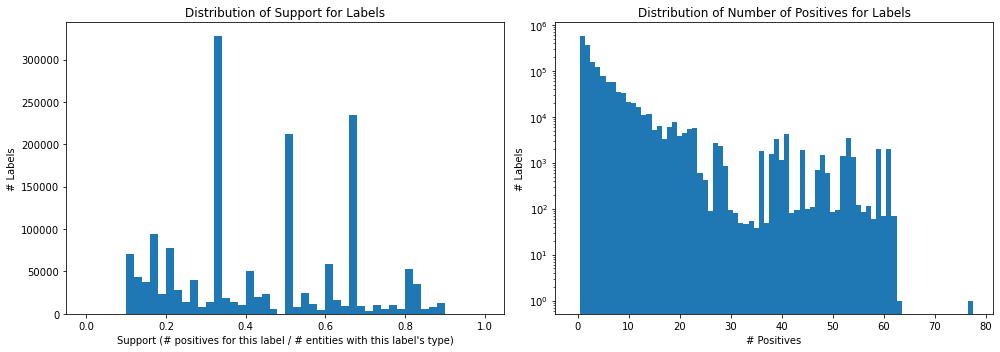

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
0,Q4830453,'business'@en,P17,'country'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.806,,,5.0,50.0,0.100000
388806,Q131734,'brewery'@en,P17,'country'@en,Q6256,'country'@en,P1279,'inflation rate'@en,1.700,,Q11229,22.0,87.0,0.252874
916860,Q3624078,'sovereign state'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.750,,,32.0,69.0,0.463768
1263509,Q6256,'country'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P4841,'total fertility rate'@en,1.250,,,17.0,26.0,0.653846
1659438,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.780,,,62.0,69.0,0.898551



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
1568,Q431289,'brand'@en,P127,'owned by'@en,Q131734,'brewery'@en,P571,'inception'@en,1847.000,,,1.0,10.0,0.100000
260959,Q131734,'brewery'@en,P17,'country'@en,Q6256,'country'@en,P1081,'Human Development Index'@en,0.829,,,16.0,87.0,0.183908
916860,Q3624078,'sovereign state'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.750,,,32.0,69.0,0.463768
1149373,Q131734,'brewery'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.885,,,48.0,87.0,0.551724
1651116,Q131734,'brewery'@en,P452,'industry'@en,Q8148,'industry'@en,P580,'start time'@en,-3500.000,,,77.0,87.0,0.885057


In [22]:
plot_label_supports_and_positives(ravl_file, ravl_cols, log_scale_positives = True)

below is output of run that includes string file

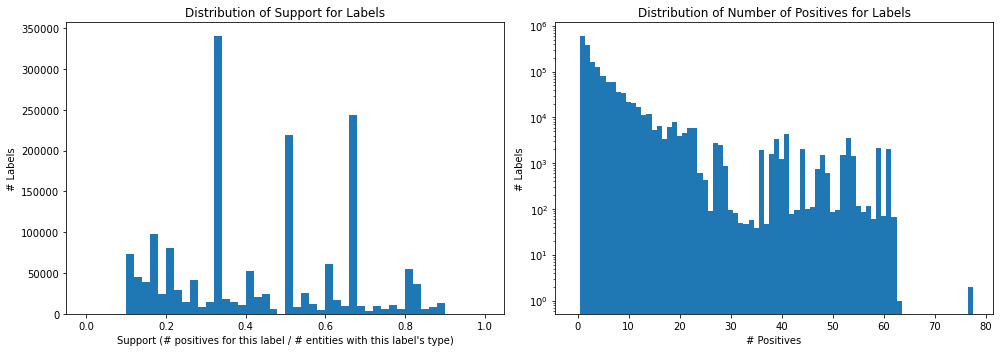

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
0,Q4830453,'business'@en,P17,'country'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.806,,,5.0,50.0,0.100000
404868,Q131734,'brewery'@en,P17,'country'@en,Q6256,'country'@en,P1279,'inflation rate'@en,1.7,,Q11229,22.0,87.0,0.252874
953065,Q3624078,'sovereign state'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.75,,,32.0,69.0,0.463768
1312480,Q6256,'country'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P4841,'total fertility rate'@en,1.25,,,17.0,26.0,0.653846
1723534,Q3624078,'sovereign state'@en,P530,'diplomatic relation'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.78,,,62.0,69.0,0.898551



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
1613,Q431289,'brand'@en,P127,'owned by'@en,Q131734,'brewery'@en,P373,'Commons category'@en,Carlsberg Group,,,1.0,10.0,0.100000
271597,Q131734,'brewery'@en,P17,'country'@en,Q6256,'country'@en,P1081,'Human Development Index'@en,0.829,,,16.0,87.0,0.183908
953065,Q3624078,'sovereign state'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.75,,,32.0,69.0,0.463768
1194151,Q131734,'brewery'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P1081,'Human Development Index'@en,0.885,,,48.0,87.0,0.551724
1714890,Q131734,'brewery'@en,P452,'industry'@en,Q8148,'industry'@en,P373,'Commons category'@en,Beer brewing,,,77.0,87.0,0.885057


In [281]:
plot_label_supports_and_positives(ravl_file, ravl_cols, log_scale_positives = True)

### RAILs

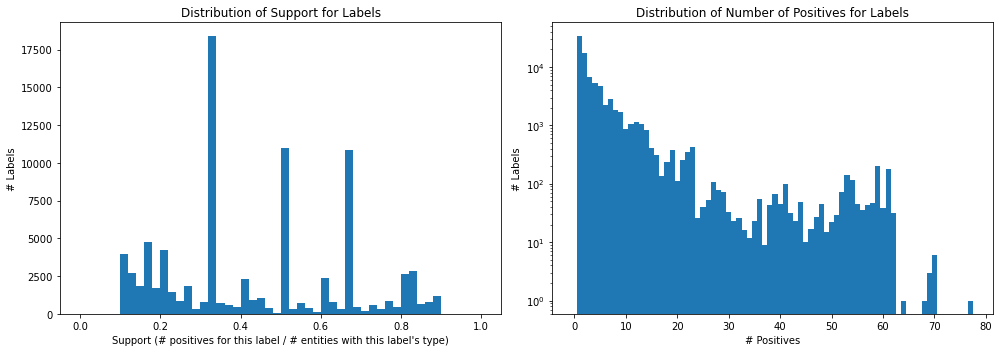

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
0,Q4830453,'business'@en,P17,'country'@en,Q179164,'unitary state'@en,P2046,'area'@en,,254469,,Q712226,5.0,50.0,0.100000
22045,Q6256,'country'@en,P17,'country'@en,Q179164,'unitary state'@en,P1198,'unemployment rate'@en,,14,,Q11229,7.0,26.0,0.269231
49205,Q3624078,'sovereign state'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P1082,'population'@en,4.93043e+07,6.23098e+07,,,34.0,69.0,0.492754
76130,Q179164,'unitary state'@en,P17,'country'@en,Q179164,'unitary state'@en,P2884,'mains voltage'@en,225,,,Q25250,11.0,16.0,0.687500
87095,Q3624078,'sovereign state'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P1279,'inflation rate'@en,-5.6,42.7,,Q11229,62.0,69.0,0.898551



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
98,Q431289,'brand'@en,P127,'owned by'@en,Q131734,'brewery'@en,P571,'inception'@en,1797,1922.5,,,1.0,10.0,0.100000
14913,Q131734,'brewery'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2134,'total reserves'@en,1.07162e+11,,,Q4917,17.0,87.0,0.195402
49205,Q3624078,'sovereign state'@en,P47,'shares border with'@en,Q3624078,'sovereign state'@en,P1082,'population'@en,4.93043e+07,6.23098e+07,,,34.0,69.0,0.492754
61552,Q131734,'brewery'@en,P17,'country'@en,Q3624078,'sovereign state'@en,P2132,'nominal GDP per capita'@en,41201,42199.5,,Q4917,50.0,87.0,0.574713
86452,Q131734,'brewery'@en,P452,'industry'@en,Q8148,'industry'@en,P580,'start time'@en,,,,,77.0,87.0,0.885057


In [23]:
plot_label_supports_and_positives(rail_file, rail_cols, log_scale_positives = True)

### All

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (8,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


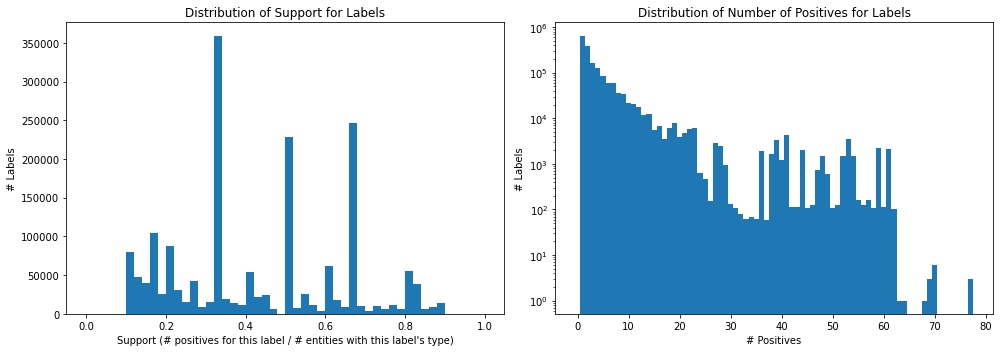

Examples of labels at several values of support...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
0,AVL,1.0,10.0,0.100000,Q431289,'brand'@en,P2665,'alcohol by volume'@en,0.4,,,,,,,,,,Q2080811
433013,RAVL,23.0,87.0,0.264368,Q131734,'brewery'@en,P17,'country'@en,,,,Q3624078,'sovereign state'@en,P1279,'inflation rate'@en,1.7,,,Q11229
961455,RAVL,42.0,87.0,0.482759,Q131734,'brewery'@en,P17,'country'@en,,,,Q20181813,'colonial power'@en,P1279,'inflation rate'@en,1.2,,,Q11229
20246,AVL,11.0,16.0,0.687500,Q179164,'unitary state'@en,P2884,'mains voltage'@en,230.0,,,,,,,,,,Q25250
40386,AIL,62.0,69.0,0.898551,Q3624078,'sovereign state'@en,P2132,'nominal GDP per capita'@en,52275.0,,,,,,,,,,Q4917



Examples of labels at several values of positives...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
0,AVL,1.0,10.0,0.100000,Q431289,'brand'@en,P2665,'alcohol by volume'@en,0.4,,,,,,,,,,Q2080811
11214,AVL,17.0,69.0,0.246377,Q3624078,'sovereign state'@en,P1279,'inflation rate'@en,1.3,,,,,,,,,,Q11229
34721,REL,34.0,69.0,0.492754,Q3624078,'sovereign state'@en,P421,'located in time zone'@en,Q6723,'UTC+02:00'@en,,,,,,,,,
40310,AIL,51.0,69.0,0.739130,Q3624078,'sovereign state'@en,P2997,'age of majority'@en,17.0,,19,,,,,,,,Q24564698
39194,REL,77.0,87.0,0.885057,Q131734,'brewery'@en,P452,'industry'@en,Q869095,'brewing'@en,,,,,,,,,


In [24]:
plot_label_supports_and_positives(all_file, all_cols, log_scale_positives = True)

## Let's look at a subset of these labels since there are a lot of them here. 
Filter on type1 = Q44 (beer)

### Optional - create a file we can view in Excel
First let's create a smaller "all-labels" file just for type1=Q44 since this will be small enough that we can view the labels in Excel.

In [25]:
df = pd.read_csv(all_file, delimiter = '\t')
df = df.loc[df.loc[:,"type1"] == "Q44"]
type1_is_q44_all_file = "{}/filtered_all_analysis_type1_is_q44.tsv".format(output_dir)
df[all_cols].to_csv(path_or_buf = type1_is_q44_all_file, sep = '\t', index = False)

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


And again here are histograms of the label supports and positives...

In [26]:
type1 = "Q44" # can change this to another type and then re-run the below cells.

### AVL - string

In [27]:
if not string_file_exists:
    print("No string labels file found, skipping this step.")
else:
    plot_label_supports_and_positives(avl_string_file, avl_cols, type1 = type1)

No string labels file found, skipping this step.


### AVL - year

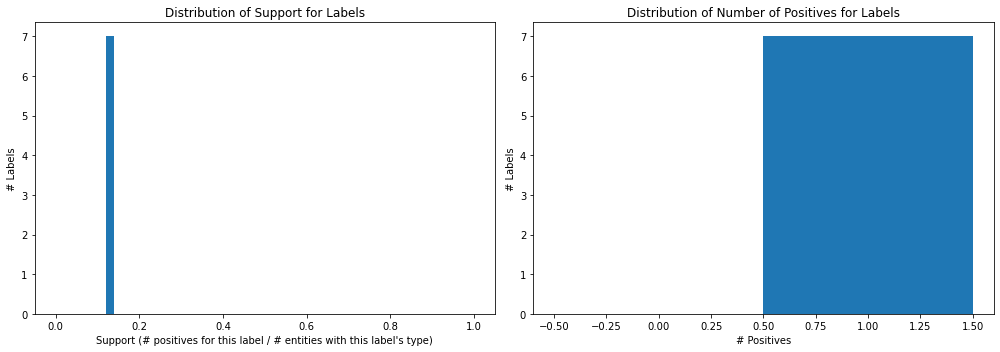

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
28,Q44,'beer'@en,P571,'inception'@en,1996.0,,,1.0,8.0,0.125
29,Q44,'beer'@en,P571,'inception'@en,1998.0,,,1.0,8.0,0.125
30,Q44,'beer'@en,P571,'inception'@en,2001.0,,,1.0,8.0,0.125
31,Q44,'beer'@en,P571,'inception'@en,2003.0,,,1.0,8.0,0.125
32,Q44,'beer'@en,P571,'inception'@en,2013.0,,,1.0,8.0,0.125



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
28,Q44,'beer'@en,P571,'inception'@en,1996.0,,,1.0,8.0,0.125
29,Q44,'beer'@en,P571,'inception'@en,1998.0,,,1.0,8.0,0.125
30,Q44,'beer'@en,P571,'inception'@en,2001.0,,,1.0,8.0,0.125
31,Q44,'beer'@en,P571,'inception'@en,2003.0,,,1.0,8.0,0.125
32,Q44,'beer'@en,P571,'inception'@en,2013.0,,,1.0,8.0,0.125


In [28]:
plot_label_supports_and_positives(avl_year_file, avl_cols, type1 = type1)

### AVL - quantity

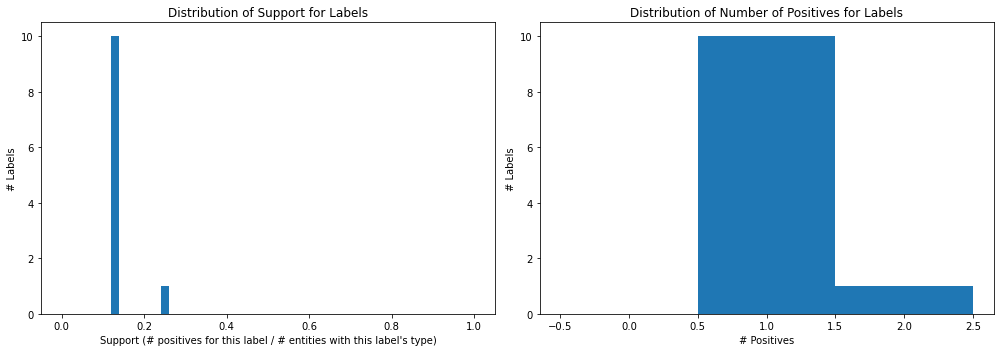

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
3231,Q44,'beer'@en,P2226,'market capitalization'@en,3896025.7,,,1.0,8.0,0.125
3232,Q44,'beer'@en,P2665,'alcohol by volume'@en,0.4,,Q2080811,1.0,8.0,0.125
3233,Q44,'beer'@en,P2665,'alcohol by volume'@en,5.0,,Q2080811,1.0,8.0,0.125
3234,Q44,'beer'@en,P2665,'alcohol by volume'@en,5.4,,Q2080811,1.0,8.0,0.125
11247,Q44,'beer'@en,P6088,'beer bitterness'@en,20.0,,,2.0,8.0,0.250



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,si_units,wd_units,positives,num_type1_ents,support
3231,Q44,'beer'@en,P2226,'market capitalization'@en,3896025.7,,,1.0,8.0,0.125
3232,Q44,'beer'@en,P2665,'alcohol by volume'@en,0.4,,Q2080811,1.0,8.0,0.125
3233,Q44,'beer'@en,P2665,'alcohol by volume'@en,5.0,,Q2080811,1.0,8.0,0.125
3234,Q44,'beer'@en,P2665,'alcohol by volume'@en,5.4,,Q2080811,1.0,8.0,0.125
11247,Q44,'beer'@en,P6088,'beer bitterness'@en,20.0,,,2.0,8.0,0.250


In [29]:
plot_label_supports_and_positives(avl_quantity_file, avl_cols, type1 = type1)

### AIL - year

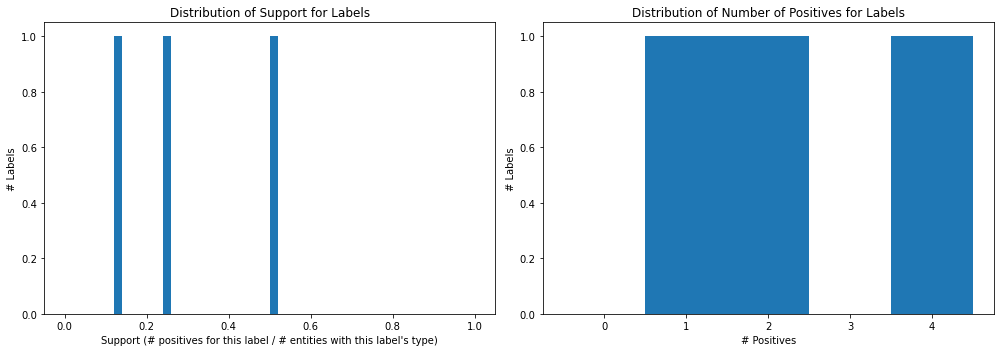

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
6,Q44,'beer'@en,P571,'inception'@en,2008,2015,,,1.0,8.0,0.125
28,Q44,'beer'@en,P571,'inception'@en,2015,,,,2.0,8.0,0.250
56,Q44,'beer'@en,P571,'inception'@en,,2008,,,4.0,8.0,0.500



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
6,Q44,'beer'@en,P571,'inception'@en,2008,2015,,,1.0,8.0,0.125
28,Q44,'beer'@en,P571,'inception'@en,2015,,,,2.0,8.0,0.250
56,Q44,'beer'@en,P571,'inception'@en,,2008,,,4.0,8.0,0.500


In [30]:
plot_label_supports_and_positives(ail_year_file, ail_cols, type1 = type1)

### AIL - quantity

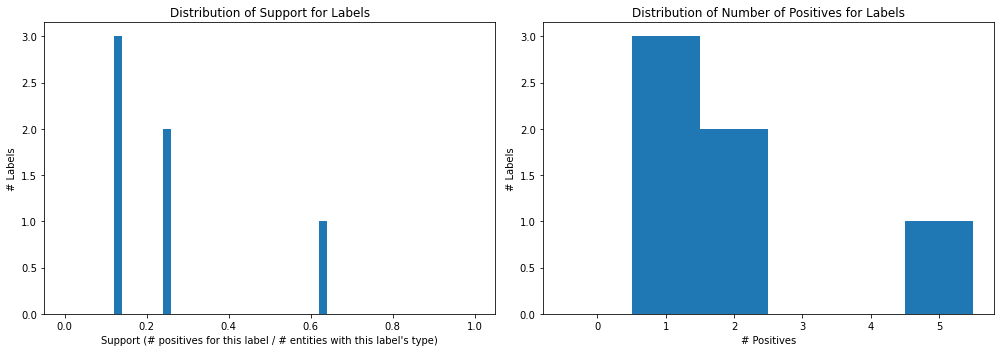

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
98,Q44,'beer'@en,P2226,'market capitalization'@en,,,,,1.0,8.0,0.125
99,Q44,'beer'@en,P2665,'alcohol by volume'@en,,2.7,,Q2080811,1.0,8.0,0.125
419,Q44,'beer'@en,P6088,'beer bitterness'@en,17.5,23,,,2.0,8.0,0.250
420,Q44,'beer'@en,P6088,'beer bitterness'@en,23,,,,2.0,8.0,0.250
951,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.7,,,Q2080811,5.0,8.0,0.625



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_ub,si_units,wd_units,positives,num_type1_ents,support
98,Q44,'beer'@en,P2226,'market capitalization'@en,,,,,1.0,8.0,0.125
99,Q44,'beer'@en,P2665,'alcohol by volume'@en,,2.7,,Q2080811,1.0,8.0,0.125
419,Q44,'beer'@en,P6088,'beer bitterness'@en,17.5,23,,,2.0,8.0,0.250
420,Q44,'beer'@en,P6088,'beer bitterness'@en,23,,,,2.0,8.0,0.250
951,Q44,'beer'@en,P2665,'alcohol by volume'@en,2.7,,,Q2080811,5.0,8.0,0.625


In [31]:
plot_label_supports_and_positives(ail_quantity_file, ail_cols, type1 = type1)

### RELs

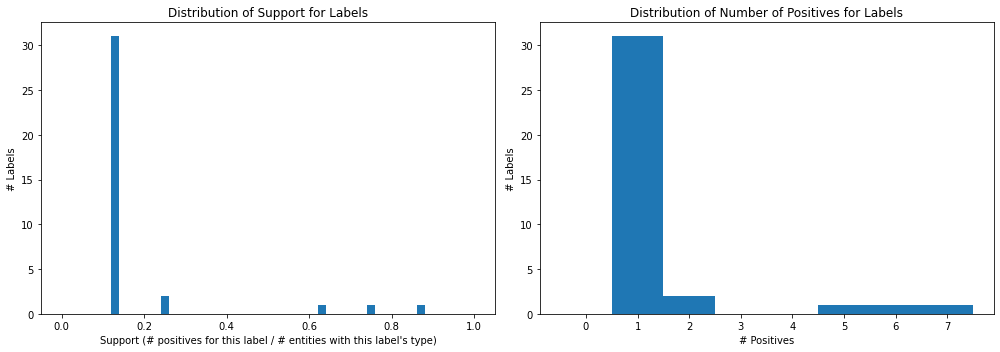

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
2281,Q44,'beer'@en,P1056,'product or material produced'@en,Q93552342,'Vergina Lager'@en,1.0,8.0,0.125
7550,Q44,'beer'@en,P166,'award received'@en,Q166423,'Brewing Industry International Awards'@en,2.0,8.0,0.250
17794,Q44,'beer'@en,P176,'manufacturer'@en,Q12877510,'Macedonian Thrace Brewery'@en,5.0,8.0,0.625
18500,Q44,'beer'@en,P127,'owned by'@en,Q12877510,'Macedonian Thrace Brewery'@en,6.0,8.0,0.750
18749,Q44,'beer'@en,P495,'country of origin'@en,Q41,'Greece'@en,7.0,8.0,0.875



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,positives,num_type1_ents,support
2281,Q44,'beer'@en,P1056,'product or material produced'@en,Q93552342,'Vergina Lager'@en,1.0,8.0,0.125
7550,Q44,'beer'@en,P166,'award received'@en,Q166423,'Brewing Industry International Awards'@en,2.0,8.0,0.250
17794,Q44,'beer'@en,P176,'manufacturer'@en,Q12877510,'Macedonian Thrace Brewery'@en,5.0,8.0,0.625
18500,Q44,'beer'@en,P127,'owned by'@en,Q12877510,'Macedonian Thrace Brewery'@en,6.0,8.0,0.750
18749,Q44,'beer'@en,P495,'country of origin'@en,Q41,'Greece'@en,7.0,8.0,0.875


In [32]:
plot_label_supports_and_positives(rel_file, rel_cols, type1 = type1)

### RAVLs

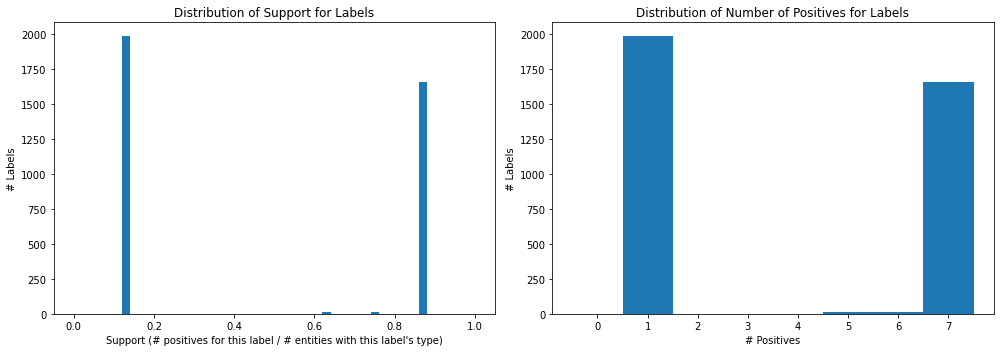

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
94393,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P2665,'alcohol by volume'@en,5.400,,Q2080811,1.0,8.0,0.125
94394,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P571,'inception'@en,2003.000,,,1.0,8.0,0.125
1246670,Q44,'beer'@en,P176,'manufacturer'@en,Q131734,'brewery'@en,P2226,'market capitalization'@en,3896025.700,,,5.0,8.0,0.625
1527400,Q44,'beer'@en,P127,'owned by'@en,Q131734,'brewery'@en,P2226,'market capitalization'@en,3896025.700,,,6.0,8.0,0.750
1645230,Q44,'beer'@en,P495,'country of origin'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.714,,,7.0,8.0,0.875



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
94393,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P2665,'alcohol by volume'@en,5.400,,Q2080811,1.0,8.0,0.125
94394,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P571,'inception'@en,2003.000,,,1.0,8.0,0.125
1246670,Q44,'beer'@en,P176,'manufacturer'@en,Q131734,'brewery'@en,P2226,'market capitalization'@en,3896025.700,,,5.0,8.0,0.625
1527400,Q44,'beer'@en,P127,'owned by'@en,Q131734,'brewery'@en,P2226,'market capitalization'@en,3896025.700,,,6.0,8.0,0.750
1645230,Q44,'beer'@en,P495,'country of origin'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.714,,,7.0,8.0,0.875


In [33]:
plot_label_supports_and_positives(ravl_file, ravl_cols, type1 = type1)

Below is output of run that includes string files

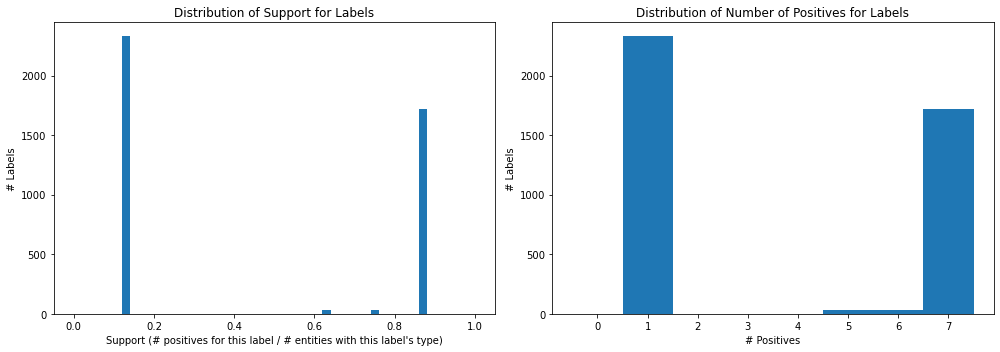

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
98084,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P2665,'alcohol by volume'@en,5.4,,Q2080811,1.0,8.0,0.125
98085,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P571,'inception'@en,2003,,,1.0,8.0,0.125
1294935,Q44,'beer'@en,P176,'manufacturer'@en,Q131734,'brewery'@en,P1329,'phone number'@en,+30-2531-038715,,,5.0,8.0,0.625
1586117,Q44,'beer'@en,P127,'owned by'@en,Q131734,'brewery'@en,P1329,'phone number'@en,+30-2531-038715,,,6.0,8.0,0.750
1708764,Q44,'beer'@en,P495,'country of origin'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.714,,,7.0,8.0,0.875



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,si_units,wd_units,positives,num_type1_ents,support
98084,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P2665,'alcohol by volume'@en,5.4,,Q2080811,1.0,8.0,0.125
98085,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P571,'inception'@en,2003,,,1.0,8.0,0.125
1294935,Q44,'beer'@en,P176,'manufacturer'@en,Q131734,'brewery'@en,P1329,'phone number'@en,+30-2531-038715,,,5.0,8.0,0.625
1586117,Q44,'beer'@en,P127,'owned by'@en,Q131734,'brewery'@en,P1329,'phone number'@en,+30-2531-038715,,,6.0,8.0,0.750
1708764,Q44,'beer'@en,P495,'country of origin'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.714,,,7.0,8.0,0.875


In [277]:
plot_label_supports_and_positives(ravl_file, ravl_cols, type1 = type1)

### RAILs

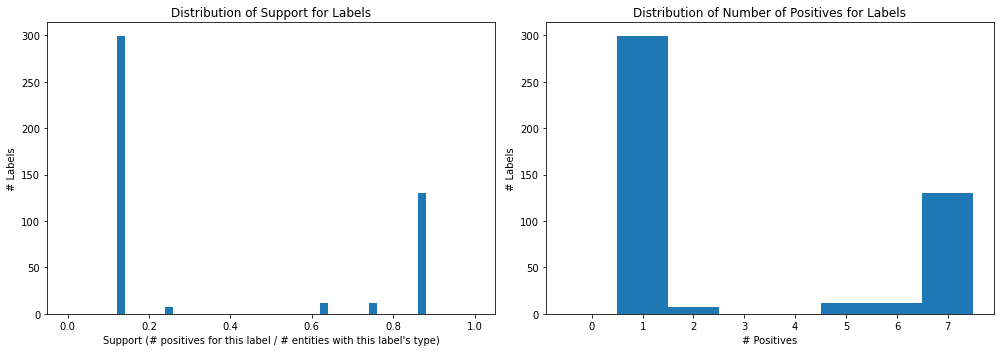

Examples of labels at several values of support...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
5439,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P2665,'alcohol by volume'@en,,,,Q2080811,1.0,8.0,0.125
21229,Q44,'beer'@en,P276,'location'@en,Q1549591,'big city'@en,P1082,'population'@en,,525816,,,2.0,8.0,0.250
64366,Q44,'beer'@en,P176,'manufacturer'@en,Q131734,'brewery'@en,P2226,'market capitalization'@en,,,,,5.0,8.0,0.625
77576,Q44,'beer'@en,P127,'owned by'@en,Q131734,'brewery'@en,P2226,'market capitalization'@en,,,,,6.0,8.0,0.750
85800,Q44,'beer'@en,P495,'country of origin'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.6875,0.887,,,7.0,8.0,0.875



Examples of labels at several values of positives...


,type1,type1_lab,prop1,prop1_lab,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units,positives,num_type1_ents,support
5439,Q44,'beer'@en,P1056,'product or material produced'@en,Q131413,'wheat beer'@en,P2665,'alcohol by volume'@en,,,,Q2080811,1.0,8.0,0.125
21229,Q44,'beer'@en,P276,'location'@en,Q1549591,'big city'@en,P1082,'population'@en,,525816,,,2.0,8.0,0.250
64366,Q44,'beer'@en,P176,'manufacturer'@en,Q131734,'brewery'@en,P2226,'market capitalization'@en,,,,,5.0,8.0,0.625
77576,Q44,'beer'@en,P127,'owned by'@en,Q131734,'brewery'@en,P2226,'market capitalization'@en,,,,,6.0,8.0,0.750
85800,Q44,'beer'@en,P495,'country of origin'@en,Q179164,'unitary state'@en,P1081,'Human Development Index'@en,0.6875,0.887,,,7.0,8.0,0.875


In [34]:
plot_label_supports_and_positives(rail_file, rail_cols, type1 = type1)

### All

/opt/anaconda3/envs/kgtk-env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (8,9,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


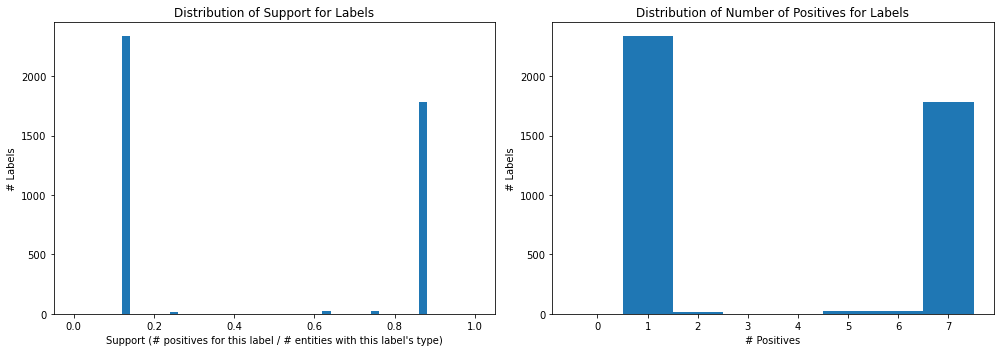

Examples of labels at several values of support...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
3231,AVL,1.0,8.0,0.125,Q44,'beer'@en,P2226,'market capitalization'@en,3896025.7,,,,,,,,,,
11247,AVL,2.0,8.0,0.250,Q44,'beer'@en,P6088,'beer bitterness'@en,20.0,,,,,,,,,,
40443,AIL,4.0,8.0,0.500,Q44,'beer'@en,P571,'inception'@en,,,2008,,,,,,,,
38230,REL,5.0,8.0,0.625,Q44,'beer'@en,P176,'manufacturer'@en,Q12877510,'Macedonian Thrace Brewery'@en,,,,,,,,,
39185,REL,7.0,8.0,0.875,Q44,'beer'@en,P495,'country of origin'@en,Q41,'Greece'@en,,,,,,,,,



Examples of labels at several values of positives...


,label_kind,positives,num_type1_ents,support,type1,type1_lab,prop1,prop1_lab,val1,val1_lab,val1_ub,type2,type2_lab,prop2,prop2_lab,val2,val2_ub,si_units,wd_units
3231,AVL,1.0,8.0,0.125,Q44,'beer'@en,P2226,'market capitalization'@en,3896025.7,,,,,,,,,,
11247,AVL,2.0,8.0,0.250,Q44,'beer'@en,P6088,'beer bitterness'@en,20.0,,,,,,,,,,
40443,AIL,4.0,8.0,0.500,Q44,'beer'@en,P571,'inception'@en,,,2008,,,,,,,,
38230,REL,5.0,8.0,0.625,Q44,'beer'@en,P176,'manufacturer'@en,Q12877510,'Macedonian Thrace Brewery'@en,,,,,,,,,
39185,REL,7.0,8.0,0.875,Q44,'beer'@en,P495,'country of origin'@en,Q41,'Greece'@en,,,,,,,,,


In [35]:
plot_label_supports_and_positives(all_file, all_cols, type1 = type1)